In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import numpy as np
import pandas as pd
import os
import sys
import shutil
import math
import random
import heapq 
import time
import copy
import itertools  
from typing import Dict, List
from PIL import Image
from io import StringIO,BytesIO 
from scipy.spatial.distance import pdist
from scipy.signal import butter, lfilter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix,roc_curve,accuracy_score,auc,roc_auc_score 
from functools import reduce
from scipy.io import loadmat
import cv2
import faiss 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
torch.cuda.set_device(1)
print (torch.cuda.current_device())

Loading faiss with AVX2 support.


1


In [2]:
tstart = time.time()
root_dir = '/data/fjsdata/MCBIR-Ins/TNSCUI2020_train/' #the path of images
trData = pd.read_csv(root_dir+"trainset.csv" , sep=',')
teData = pd.read_csv(root_dir+"testset.csv" , sep=',')
#trainset 
trN, trI, trM, trY = [],[],[],[]
for iname, itype in np.array(trData).tolist():
    try:
        trN.append(iname)
        trY.append(itype) #0 refer to Benign, and 1 refers to malignant
        image_path = os.path.join(root_dir, 'image', iname)
        img = cv2.resize(cv2.imread(image_path).astype(np.float32), (256, 256))#(256,256,3)
        trI.append(img)
        mask_path = os.path.join(root_dir,'mask', iname)
        mask = cv2.resize(cv2.imread(mask_path).astype(np.float32), (256, 256))#(256,256)
        trM.append(mask)
    except:
        print(iname+":"+str(image_path))
    sys.stdout.write('\r{} / {} '.format(len(trN),trData.shape[0]))
    sys.stdout.flush()
print('The length of trainset is %d'%len(trN))
#testset
teN, teI, teM, teY = [],[],[],[]
for iname, itype in np.array(teData).tolist():
    try:
        teN.append(iname)
        teY.append(itype) #0 refer to Benign, and 1 refers to malignant
        image_path = os.path.join(root_dir, 'image', iname)
        img = cv2.resize(cv2.imread(image_path).astype(np.float32), (256, 256))#(256,256,3)
        teI.append(img)
        mask_path = os.path.join(root_dir,'mask', iname)
        mask = cv2.resize(cv2.imread(mask_path).astype(np.float32), (256, 256))#(256,256)
        teM.append(mask)
    except:
        print(iname+":"+str(image_path))
    sys.stdout.write('\r{} / {} '.format(len(teN),teData.shape[0]))
    sys.stdout.flush()
print('The length of testset is %d'%len(teN))

elapsed = time.time() - tstart
print('Completed data handle in %d seconds' % int(elapsed))

3279 / 3279 The length of trainset is 3279
365 / 365 The length of testset is 365
Completed data handle in 119 seconds


In [3]:
model_urls = {
    'vgg11': 'https://download.pytorch.org/models/vgg11-bbd30ac9.pth',
    'vgg13': 'https://download.pytorch.org/models/vgg13-c768596a.pth',
    'vgg16': 'https://download.pytorch.org/models/vgg16-397923af.pth',
    'vgg19': 'https://download.pytorch.org/models/vgg19-dcbb9e9d.pth',
    'vgg11_bn': 'https://download.pytorch.org/models/vgg11_bn-6002323d.pth',
    'vgg13_bn': 'https://download.pytorch.org/models/vgg13_bn-abd245e5.pth',
    'vgg16_bn': 'https://download.pytorch.org/models/vgg16_bn-6c64b313.pth',
    'vgg19_bn': 'https://download.pytorch.org/models/vgg19_bn-c79401a0.pth',
}

class VGG(nn.Module):

    def __init__(self, features, num_classes=2, init_weights=True):
        super(VGG, self).__init__()
        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


cfgs = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


def vgg11(progress=True, **kwargs):
    r"""VGG 11-layer model (configuration "A") from
    `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    model = VGG(make_layers(cfgs['A'], batch_norm=False), **kwargs)
    return model


def vgg11_bn(progress=True, **kwargs):
    r"""VGG 11-layer model (configuration "A") with batch normalization
    `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    model = VGG(make_layers(cfgs['A'], batch_norm=True), **kwargs)
    return model


def vgg13(progress=True, **kwargs):
    r"""VGG 13-layer model (configuration "B")
    `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    model = VGG(make_layers(cfgs['B'], batch_norm=False), **kwargs)
    return model


def vgg13_bn(progress=True, **kwargs):
    r"""VGG 13-layer model (configuration "B") with batch normalization
    `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    model = VGG(make_layers(cfgs['B'], batch_norm=True), **kwargs)
    return model


def vgg16(progress=True, **kwargs):
    r"""VGG 16-layer model (configuration "D")
    `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    model = VGG(make_layers(cfgs['D'], batch_norm=False), **kwargs)
    return model


def vgg16_bn(progress=True, **kwargs):
    r"""VGG 16-layer model (configuration "D") with batch normalization
    `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    model = VGG(make_layers(cfgs['D'], batch_norm=True), **kwargs)
    return model


def vgg19(progress=True, **kwargs):
    r"""VGG 19-layer model (configuration "E")
    `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    model = VGG(make_layers(cfgs['E'], batch_norm=False), **kwargs)
    return model


def vgg19_bn(progress=True, **kwargs):
    r"""VGG 19-layer model (configuration 'E') with batch normalization
    `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    model = VGG(make_layers(cfgs['E'], batch_norm=True), **kwargs)
    return model

 328 / 328 : loss = 0.853719Eopch:     1 mean_loss = 2.030319
 328 / 328 : loss = 0.647072Eopch:     2 mean_loss = 0.699861
 328 / 328 : loss = 0.686738Eopch:     3 mean_loss = 0.755035
 328 / 328 : loss = 0.950532Eopch:     4 mean_loss = 0.752735
 328 / 328 : loss = 0.647347Eopch:     5 mean_loss = 0.724625
 328 / 328 : loss = 0.747551Eopch:     6 mean_loss = 0.685295
 328 / 328 : loss = 0.993086Eopch:     7 mean_loss = 0.851935
 328 / 328 : loss = 0.609801Eopch:     8 mean_loss = 0.737392
 328 / 328 : loss = 0.551208Eopch:     9 mean_loss = 0.702758
 328 / 328 : loss = 0.678591Eopch:    10 mean_loss = 0.691197
best_loss = 0.685295
 36 / 37 Sensitivity(TPR) of Benign: 0.162791
Sensitivity(TPR) of Malignant: 0.963731
AUC (Area Under Curve) of Micro: 0.474364


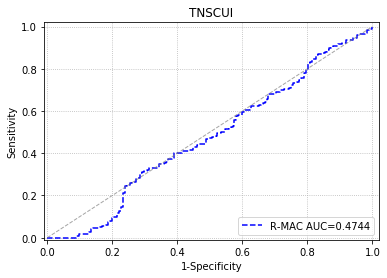

In [9]:
#define model
model = vgg16_bn().cuda()#initialize model
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #define optimizer
ce_loss  = nn.CrossEntropyLoss().cuda() #define cross-entropy loss
#train model
best_net, best_loss = None, float('inf')
batchSize = 10
for epoch in range(10):#iteration
    losses = []
    shuffled_idx = np.random.permutation(np.arange(len(trI)))
    trI_batch = np.array(trI)[shuffled_idx]
    trY_batch = np.array(trY)[shuffled_idx]
    num_batches = len(trI) // batchSize + 1
    for i in range(num_batches):
        optimizer.zero_grad()#grad vanish
        min_idx = i * batchSize
        max_idx = np.min([len(trI), (i+1)*batchSize])
        X_batch = torch.from_numpy(trI_batch[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        Y_batch = torch.from_numpy(trY_batch[min_idx:max_idx]).type(torch.LongTensor).cuda()
        #forword
        Out_batch = model(X_batch.permute(0, 3, 1, 2))#permute the dims of matrix
        loss = ce_loss(Out_batch,Y_batch)#loss
        #backward
        loss.backward()
        optimizer.step()#update parameters
        #show loss
        sys.stdout.write('\r {} / {} : loss = {}'.format(i+1, num_batches, float('%0.6f'%loss.item())))
        sys.stdout.flush()     
        losses.append(loss.item())
    print("Eopch: %5d mean_loss = %.6f" % (epoch + 1, np.mean(losses)))
    if np.mean(losses) < best_loss:
        best_loss = np.mean(losses)
        best_net = copy.deepcopy(model)
print("best_loss = %.6f" % (best_loss))
#release gpu memory
model = model.cpu()
ce_loss = ce_loss.cpu()
torch.cuda.empty_cache()
#test model
teY_pred = []
teY_prob = []
num_batches = len(teI) // batchSize + 1
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(teI), (i+1)*batchSize])
    x_batch = torch.from_numpy(np.array(teI[min_idx:max_idx])).type(torch.FloatTensor).cuda()
    out_batch = best_net(x_batch.permute(0, 3, 1, 2))#forword
    out_batch = F.log_softmax(out_batch,dim=1) 
    prob = out_batch.max(1,keepdim=True)[0]
    teY_prob.extend(prob.cpu().data.numpy().tolist())
    pred = out_batch.max(1,keepdim=True)[1]
    teY_pred.extend(pred.cpu().data.numpy().flatten().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()
    
#TNR= TN / (FP+TN) ->low misdiagnosis rate->Specificity
#TPR= TP / (TP+FN) -> low missed diagnosis rate->Sensitivity
#ROC curves: y axis:Sensitivity, x axis:1-Specificity
#confusion matrix
labels = list(set(teY))
cm = confusion_matrix(teY, teY_pred, labels=labels) 
print ('Sensitivity(TPR) of Benign: %.6f'%float(cm[0][0]/np.sum(cm[0]))) 
print ('Sensitivity(TPR) of Malignant: %.6f'%float(cm[1][1]/np.sum(cm[1])))
#auc and roc
teY_one_hot = label_binarize(np.array(teY), np.arange(len(labels)))
auc_score = roc_auc_score(teY_one_hot, np.array(teY_prob), average='micro')#macro
print ('AUC (Area Under Curve) of Micro: %.6f'% auc_score)
#plot roc curve
fpr_tce, tpr_tce, thresholds = roc_curve(teY_one_hot.ravel(),np.array(teY_prob).ravel()) 
#plt.plot(fpr_ce, tpr_ce, c = 'r', ls = '--', label = u'ATH(our) AUC=%.4f' % auc_score)
plt.plot(fpr_tce, tpr_tce, c = 'b', ls = '--', label = u'R-MAC AUC=%.4f' % auc_score) 
plt.plot((0, 1), (0, 1), c = '#808080', lw = 1, ls = '--', alpha = 0.7)
plt.xlim((-0.01, 1.02))
plt.ylim((-0.01, 1.02))
plt.xticks(np.arange(0, 1.1, 0.2))
plt.yticks(np.arange(0, 1.1, 0.2))
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.grid(b=True, ls=':')
plt.legend(loc='lower right')
plt.title('TNSCUI')
plt.show()

In [10]:
#release gpu memory and save model in CPU
model = model.cpu()
ce_loss = ce_loss.cpu()
best_net = best_net.cpu()
torch.cuda.empty_cache() 
torch.save(best_net.state_dict(), '/data/tmpexec/R_MAC.pkl')

In [4]:
'''
#Code: https://github.com/PyRetri/PyRetri
       https://github.com/almazan/deep-image-retrieval
       https://github.com/noagarcia/keras_rmac
#Paper: ICLR2016《Particular object retrieval with integral max-pooling of CNN activations》
        IJCV2017《End-to-end Learning of Deep Visual Representations for Image Retrieval》
'''
class RMAC():
    """
    Regional Maximum activation of convolutions (R-MAC).
    c.f. https://arxiv.org/pdf/1511.05879.pdf
    Args:
        level_n (int): number of levels for selecting regions.
    """
    def __init__(self,level_n:int):
        super(RMAC, self).__init__()
        self.first_show = True
        self.cached_regions = dict()
        self.level_n = level_n

    def _get_regions(self, h: int, w: int) -> List:
        """
        Divide the image into several regions.
        Args:
            h (int): height for dividing regions.
            w (int): width for dividing regions.
        Returns:
            regions (List): a list of region positions.
        """
        if (h, w) in self.cached_regions:
            return self.cached_regions[(h, w)]

        m = 1
        n_h, n_w = 1, 1
        regions = list()
        if h != w:
            min_edge = min(h, w)
            left_space = max(h, w) - min(h, w)
            iou_target = 0.4
            iou_best = 1.0
            while True:
                iou_tmp = (min_edge ** 2 - min_edge * (left_space // m)) / (min_edge ** 2)

                # small m maybe result in non-overlap
                if iou_tmp <= 0:
                    m += 1
                    continue

                if abs(iou_tmp - iou_target) <= iou_best:
                    iou_best = abs(iou_tmp - iou_target)
                    m += 1
                else:
                    break
            if h < w:
                n_w = m
            else:
                n_h = m

        for i in range(self.level_n):
            region_width = int(2 * 1.0 / (i + 2) * min(h, w))
            step_size_h = (h - region_width) // n_h
            step_size_w = (w - region_width) // n_w

            for x in range(n_h):
                for y in range(n_w):
                    st_x = step_size_h * x
                    ed_x = st_x + region_width - 1
                    assert ed_x < h
                    st_y = step_size_w * y
                    ed_y = st_y + region_width - 1
                    assert ed_y < w
                    regions.append((st_x, st_y, ed_x, ed_y))

            n_h += 1
            n_w += 1

        self.cached_regions[(h, w)] = regions
        return regions

    def __call__(self, fea:torch.tensor) -> torch.tensor:
        final_fea = None
        if fea.ndimension() == 4:
            h, w = fea.shape[2:]       
            regions = self._get_regions(h, w)
            for _, r in enumerate(regions):
                st_x, st_y, ed_x, ed_y = r
                region_fea = (fea[:, :, st_x: ed_x, st_y: ed_y].max(dim=3)[0]).max(dim=2)[0]
                region_fea = region_fea / torch.norm(region_fea, dim=1, keepdim=True)
                if final_fea is None:
                    final_fea = region_fea
                else:
                    final_fea = final_fea + region_fea
        else:# In case of fc feature.
            assert fea.ndimension() == 2
            if self.first_show:
                print("[RMAC Aggregator]: find 2-dimension feature map, skip aggregation")
                self.first_show = False
            final_fea = fea
        return final_fea

In [6]:
#load model and transfer to GPU
device = torch.device("cuda")
best_net = vgg16_bn()
best_net.load_state_dict(torch.load( '/data/tmpexec/R_MAC.pkl'))
best_net.to(device)
#1. Extract features based on backbone and Aggregate R-MAC
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook
best_net.features.register_forward_hook(get_activation('features'))

batchSize=10
rmac = RMAC(level_n=3)
trF = []
num_batches = len(trI) // batchSize + 1
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(trI), (i+1)*batchSize])
    x_batch = torch.from_numpy(np.array(trI[min_idx:max_idx])).type(torch.FloatTensor).cuda()
    out_batch = best_net(x_batch.permute(0, 3, 1, 2))#forword
    feat_batch = activation['features'].squeeze()
    feat_ret_batch = rmac(feat_batch)
    trF.extend(feat_ret_batch.cpu().numpy().tolist())
teF = []
num_batches = len(teI) // batchSize + 1
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(teI), (i+1)*batchSize])
    x_batch = torch.from_numpy(np.array(teI[min_idx:max_idx])).type(torch.FloatTensor).cuda()
    out_batch = best_net(x_batch.permute(0, 3, 1, 2))#forword
    feat_batch = activation['features'].squeeze()
    feat_ret_batch = rmac(feat_batch)
    teF.extend(feat_ret_batch.cpu().numpy().tolist())

#compute the size of lesion
#compute the size of lesion
def Func_IOU_size(pred,target):
    ious = []
    # ignore IOU for background class
    pred_inds = pred != 0
    pred_sum = pred_inds.sum()
    target_inds = target != 0
    target_sum = target_inds.sum()
    ious.append(round(float(min(pred_sum,target_sum)/max(pred_sum,target_sum)),4))
    return np.mean(ious)
# buliding index of trainset
tstart = time.time()
cpu_index = faiss.IndexFlatL2(512) #
gpu_index = faiss.index_cpu_to_all_gpus(cpu_index) #make all gpu usable
gpu_index.add(np.ascontiguousarray(trF, dtype=np.float32)) #add data(must be float32) to index
elapsed = time.time() - tstart    
print('Completed buliding index in %d seconds' % int(elapsed))
for topk in [10]:
    mAP = [] #mean average precision
    mIoU = []
    scores, neighbors = gpu_index.search(np.array(teF).astype('float32'), k=topk)
    for i, teVal in enumerate(teF):
        stype = teY[i]
        #perfromance
        pos_len = 0
        rank_len = 0
        #for j in ranklist:
        for j in neighbors[i].tolist():
            dtype = trY[j]
            rank_len=rank_len+1
            if stype==dtype:  #hit
                pos_len = pos_len +1
                mAP.append(pos_len/rank_len) 
            else: 
                mAP.append(0)
            mIoU.append(Func_IOU_size(teM[i],trM[j]))
    print("mAP={:.4f}, mIoU={:.4f}".format(np.mean(mAP),np.mean(mIoU)))

Completed buliding index in 22 seconds
mAP=0.4319, mIoU=0.4070


In [21]:
#compute the size of lesion
def Func_IOU_size(pred,target):
    ious = []
    # ignore IOU for background class
    pred_inds = pred != 0
    pred_sum = pred_inds.sum()
    target_inds = target != 0
    target_sum = target_inds.sum()
    ious.append(round(float(min(pred_sum,target_sum)/max(pred_sum,target_sum)),4))
    return np.mean(ious)
for topk in [10]:
    mAP = [] #mean average precision
    mIoU = []
    scores, neighbors = gpu_index.search(np.array(teF).astype('float32'), k=topk)
    for i, teVal in enumerate(teF):
        stype = teY[i]
        #perfromance
        pos_len = 0
        rank_len = 0
        #for j in ranklist:
        for j in neighbors[i].tolist():
            dtype = trY[j]
            rank_len=rank_len+1
            if stype==dtype:  #hit
                pos_len = pos_len +1
                mAP.append(pos_len/rank_len) 
            else: 
                mAP.append(0)
            mIoU.append(Func_IOU_size(teM[i],trM[j]))
    print("mAP={:.4f}, mIoU={:.4f}".format(np.mean(mAP),np.mean(mIoU)))

mAP=0.4319, mIoU=0.4070


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Counter({0.0: 192576, 255.0: 3852, 251.01562: 18, 107.578125: 15, 195.23438: 6, 3.984375: 6, 41.88263: 3, 116.54297: 3, 127.359924: 3, 119.17328: 3, 92.27875: 3, 5.649719: 3, 198.26935: 3, 227.10938: 3, 250.01953: 3, 252.2763: 3, 36.964417: 3, 124.51172: 3, 254.76654: 3, 123.03314: 3, 22.77008: 3, 43.828125: 3, 251.12457: 3, 156.83807: 3, 106.286316: 3, 203.20312: 3, 3.8442993: 3, 170.06744: 3, 128.79181: 3, 155.39062: 3, 246.82892: 3, 69.39972: 3, 76.24786: 3, 243.04688: 3, 1.1050415: 3, 107.31354: 3, 181.46027: 3, 117.14996: 3, 51.796875: 3, 240.63446: 3, 43.65692: 3, 209.4754: 3, 147.42188: 3, 198.64288: 3, 187.26562: 3, 204.3393: 3, 153.44513: 3, 237.17926: 3, 3.7820435: 3, 186.0672: 3, 22.910156: 3})
4032
192576


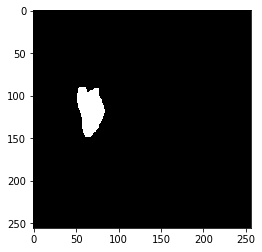

In [22]:
from collections import Counter
print(Counter(np.array(trM[0]).flatten()))
pred_inds = trM[0]!= 0
pred_sum = pred_inds.sum()
print (pred_sum)
pred_inds = trM[0]== 0
pred_sum = pred_inds.sum()
print (pred_sum)
imgplot = plt.imshow(trM[0])
plt.show()

In [2]:
datas = pd.read_csv("/data/fjsdata/MCBIR-Ins/TNSCUI2020_train/train.csv" , sep=',')
datas = datas[['ID','CATE']]
print(datas['CATE'].value_counts())
trData, teData = train_test_split(datas, test_size=0.1) #split trainset and testset
print(trData['CATE'].value_counts())
print(teData['CATE'].value_counts())
trData.to_csv( '/data/fjsdata/MCBIR-Ins/TNSCUI2020_train/trainset.csv',index=False)
teData.to_csv( '/data/fjsdata/MCBIR-Ins/TNSCUI2020_train/testset.csv',index=False)

1    2003
0    1641
Name: CATE, dtype: int64
1    1810
0    1469
Name: CATE, dtype: int64
1    193
0    172
Name: CATE, dtype: int64
